In [65]:
import pandas as pd
import numpy as np

import regex
import gensim
import collections
import multiprocessing
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.layers import Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout, Input, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/ll3165/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [113]:
# Load and format files

document = pd.read_csv('embed_train.csv', index_col=None)
#document=document.iloc[:,1:]



In [114]:
dat = document[['Sentence','label']]
#dat['label'] = pd.to_numeric(dat['label'])

lines = []
#i = 0
for x in dat['Sentence']:
#    i+=1
    lines.append(len(list(filter(str.strip ,x.split('\n')))))
#    print(i)

dat = dat.assign(length = lines)

articles = []
for x in dat['Sentence']:
    for i in range(len(list(filter(str.strip ,x.split('\n'))))):
        articles.append(x.split('\n')[i])

tags = []
for index, row in dat.iterrows():
    for i in range(row['length']):
        tags.append(row['label'])

data = pd.DataFrame({'lines': articles, 'label':tags})
print('Cell processing completed!')

Cell processing completed!


In [118]:
pattern = "[^a-z|A-Z|\s]|\\b\w{1}\\b"
X = data[data.columns[1]]
X = pd.Series([regex.sub(pattern,'', x) for x in X])
y = data[data.columns[0]]
labels = tags

In [116]:
data.columns

Index(['label', 'lines'], dtype='object')

In [117]:
y = tags
#y = y.values.astype(str)
X = data[data.columns[1]]
X = pd.Series([regex.sub(pattern,'', x) for x in X])
X = X.values.astype(str)
# X = np.array([x.split(' ') for x in X])
# articles = np.array([' '.join(x) for x in X])
# X = np.array([' '.join(x) for x in X])
X = [word_tokenize(x) for x in X]
strings = [' '.join(x) for x in X]
string = ' '.join(strings)
n_words = len(set(string.split(' ')))
print('Cell processing completed!')


Cell processing completed!


In [82]:
n_words

2642

In [83]:
tokenizer = Tokenizer(nb_words = n_words)
tokenizer.fit_on_texts(strings)
sequences = tokenizer.texts_to_sequences(strings)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

datas = pad_sequences(sequences, maxlen=100)
lab = np_utils.to_categorical(np.asarray(labels))

Found 2499 unique tokens.


In [9]:
# Import the Word2Vec models
wv_model = gensim.models.KeyedVectors.load_word2vec_format('wiki.en.bin', binary = True)
vector_sizes1 = 100
my_model = gensim.models.KeyedVectors.load_word2vec_format('fil9.bin', binary = True)
print('Cell processing completed!')

Cell processing completed!


In [100]:
my_model.vector_size

100

In [10]:
# Build embedding index dictionary and embedding matrix
vector_sizes2 = wv_model.vector_size
vector_size = vector_sizes1 + vector_sizes2

embeddings_index = {}
for i in range(len(wv_model.index2word)):
    word = wv_model.index2word[i]
    coefs = np.asarray(wv_model.vectors[i], dtype='float32')
    embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, vector_size))
for word, i in word_index.items():
    wv_vec = embeddings_index.get(word)

    if wv_vec is not None and word in my_model.wv.vocab:
        embedding_vector = np.append(wv_vec, my_model[word])
    elif wv_vec is not None and word not in my_model.wv.vocab:
        embedding_vector = np.append(wv_vec, np.zeros((1, 100)))
    elif wv_vec is not None and word in my_model.wv.vocab:
        embedding_vector = np.append(np.zeros((1, 300)), my_model[word])

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('Cell processing completed!')

Cell processing completed!


In [84]:
# Subsetting data
X_train, X_eval, y_train, y_eval = train_test_split(datas, lab, test_size=0.3, shuffle=True, random_state=8)
X_eval, X_test, y_eval, y_test = train_test_split(X_eval, y_eval, test_size=0.33, shuffle=True, random_state=4)

In [101]:
# Build up textCNN model
vocab_size = len(embedding_matrix)
maxlen = 100
seq = Input(shape=[maxlen],name='x_seq')
output_len = len(set(y))
#Embedding layers
emb = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(seq)

# conv layers
convs = []
filter_sizes = [2,3,4,5,6,7,8]
for fsz in filter_sizes:
    conv1 = Conv1D(128,kernel_size=fsz,activation='tanh')(emb)
    pool1 = MaxPooling1D(maxlen-fsz+1)(conv1)
    pool1 = Flatten()(pool1)
    convs.append(pool1)
merge = concatenate(convs,axis=1)
out = Dropout(0.5)(merge)
#output = Dense(output_len,activation='relu')(out)
output = Dense(output_len,activation='sigmoid')(out)
model = Model([seq],output)

print('Cell processing completed!')

Cell processing completed!


In [102]:
'''
Train model 
Skip if we already have a model
'''
# Compile and Train model
model.compile(optimizer=Adam(lr = 0.0005), loss='binary_crossentropy', metrics=['acc'], )
save_best = ModelCheckpoint('articles0.hdf', save_best_only=True, monitor='val_loss', mode='min')
print('Training model. Plz be patient......')
hist = model.fit(X_train, y_train, validation_data=(X_eval, y_eval),verbose=2,epochs=66, callbacks=[save_best], batch_size=64)

print('Training completed!')

Training model. Plz be patient......
Train on 210 samples, validate on 60 samples
Epoch 1/80
 - 18s - loss: 0.8577 - acc: 0.5738 - val_loss: 0.7861 - val_acc: 0.5167
Epoch 2/80
 - 4s - loss: 0.6927 - acc: 0.6167 - val_loss: 0.6772 - val_acc: 0.5833
Epoch 3/80
 - 4s - loss: 0.6501 - acc: 0.6786 - val_loss: 0.6920 - val_acc: 0.5917
Epoch 4/80
 - 4s - loss: 0.5064 - acc: 0.7500 - val_loss: 0.6941 - val_acc: 0.5750
Epoch 5/80
 - 4s - loss: 0.4651 - acc: 0.7762 - val_loss: 0.6904 - val_acc: 0.6167
Epoch 6/80
 - 4s - loss: 0.4072 - acc: 0.8190 - val_loss: 0.6494 - val_acc: 0.6833
Epoch 7/80
 - 4s - loss: 0.3507 - acc: 0.8286 - val_loss: 0.6668 - val_acc: 0.6833
Epoch 8/80
 - 4s - loss: 0.2860 - acc: 0.8881 - val_loss: 0.6881 - val_acc: 0.6833
Epoch 9/80
 - 4s - loss: 0.2185 - acc: 0.9190 - val_loss: 0.6997 - val_acc: 0.7000
Epoch 10/80
 - 4s - loss: 0.1847 - acc: 0.9476 - val_loss: 0.6468 - val_acc: 0.6583
Epoch 11/80
 - 4s - loss: 0.1638 - acc: 0.9524 - val_loss: 0.6667 - val_acc: 0.6917
Ep

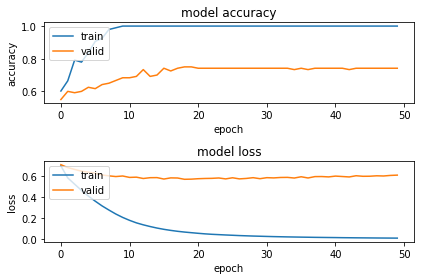

In [22]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout()
#fig

In [103]:
# Prediction on test
model.load_weights(filepath='articles0.hdf')
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

[[TN, FP], [FN, TP]] = confusion_matrix(y_true, y_pred, labels=[0, 1]).astype(float)
accuracy = (TP+TN)/(TP+TN+FP+FN)
auc = roc_auc_score(y_true, y_pred)
specificity = TN/(FP+TN)
precision = TP/(TP+FP)
sensitivity = recall = TP/(TP+FN)
fscore = 2*TP/(2*TP+FP+FN)

print('acc: ', accuracy)
print('auc: ', auc)
print('precision: ', precision)
print('recall: ', recall)
print('fscore: ', fscore)

acc:  0.8
auc:  0.7782805429864253
precision:  0.7619047619047619
recall:  0.9411764705882353
fscore:  0.8421052631578947


## Make prediction

In [82]:
model.load_weights(filepath='articles0.hdf')

new_dat = pd.read_csv('embed_to_predict.csv')
new_dat = new_dat['Sentence']

new_dat = new_dat[new_dat.notnull()]
new_lines = []
#i = 0
for x in new_dat:
#    i+=1
    new_lines.append(len(list(filter(str.strip ,x.split('\n')))))
#    print(i)


#new_dat = new_dat.assign(length = new_lines)



In [105]:
# Test our model
import json

#model.load_weights(filepath='articles0.hdf')

new_data = pd.read_csv('embed_to_predict.csv')
new_dat = new_data['Sentence']

new_dat = new_dat[new_dat.notnull()]


new_articles = []
for x in new_dat:
    for i in range(len(list(filter(str.strip ,x.split('\n'))))):
        new_articles.append(x.split('\n')[i])

#test_tags = []
# for index, row in test_dat.iterrows():
#     for i in range(row['length']):
#         test_tags.append(row['tags'])

# test_data = pd.DataFrame({'lines': test_articles, 'tags': test_tags})
# #data = data[data.lines.notnull()][data['lines'] != ''][data.tags.notnull()]
# punctuation = "[\s+\t+\.\!\:\/_,$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）：；–•\−\-\uf0fc+\uf0a7]|[0-9]+"


# test_X = test_data[test_data.columns[0]]
# test_X = pd.Series([regex.sub(punctuation,'', x) for x in test_X])
# test_y = test_data[test_data.columns[1]]

# c_label = pd.DataFrame({'tags':list(set(test_y)), 'category':range(len(set(test_y)))})
# y_label = pd.DataFrame({'tags':test_y})
# test_labels = pd.merge(y_label, c_label, how = 'left', on=['tags'])

# new_articles = [regex.sub(punctuation,'', x) for x in test_articles]
# new_articles = [jieba.lcut(x) for x in test_articles]
# new_articles = [' '.join(x) for x in test_articles]
#articles = list(filter(str.strip, articles))

new_tokenizer = Tokenizer(nb_words=550)
new_tokenizer.fit_on_texts(new_articles)
new_sequences = tokenizer.texts_to_sequences(new_articles)

new_word_index = new_tokenizer.word_index
print('Found %s unique tokens.' % len(new_word_index))

new_datas = pad_sequences(new_sequences, maxlen=100)

#new_lab = np_utils.to_categorical(np.asarray(test_labels[test_labels.columns[1]]))
print('Shape of data tensor:', new_datas.shape)
#print('Shape of label tensor:', new_lab.shape)


predictions = model.predict(new_datas)
pred_labels = np.argmax(predictions, axis=1)

Found 31417 unique tokens.
Shape of data tensor: (10142, 100)


In [110]:
count = {}
for x in tags:
    count[x] = count.get(x, 0) + 1
    

In [111]:
count

{0: 118, 1: 182}

In [111]:
pred_dat = new_data.assign(prediction = pred_labels)
pred_dat.to_csv('pred_dat.csv', index = False)